<div style="background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GAICo: Evaluating Structured Outputs</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Time Series Evaluation</p>
</div>
<br>

This notebook demonstrates how to use the **TimeSeriesElementDiff** and **TimeSeriesDTW** metrics from the `gaico.metrics.structured` module to compare generated and reference time series.

These metrics are ideal for evaluating forecasting models, synthetic data, or any task requiring comparison of temporal sequences.

### Key Features

- **TimeSeriesElementDiff**: Aligns time points and values, with adjustable weights.
- **TimeSeriesDTW**: Uses Dynamic Time Warping to align sequences with temporal drift or phase shift.

Data is taken from: [Monash Time Series Forecasting Repository](https://forecastingdata.org) and the [Pedestrian Counting from Melbourne](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-sensor-locat[…]able/?location=13,-37.80804,144.95782&basemap=mbs-7a7333)

Author: Michael "Xander" Widener


## Environment Setup & Imports

The cell below adjusts `sys.path` to find the gaico module if run from examples directory.
This block is primarily for local execution from the `examples/` folder if gaico is not installed.||


In [ ]:
# To import `gaico` from the project root, we need to ensure the path is set correctly.
# If this script is run as a standalone file, it will add the project root to the system path.

import sys
import os

notebook_dir = os.getcwd()  # Get the current working directory of the notebook
# Construct the path to the project root (two levels up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")

Added project root to sys.path: /Users/nitingupta/usc/ai4s/libraries/GenAIResultsComparator/examples


In [2]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import urllib.request
from scipy.interpolate import interp1d
from gaico.metrics.structured import TimeSeriesElementDiff, TimeSeriesDTW

## Data Reading & Setup

We will download a dataset from the monash repository as an example in this notebook.

This dataset contains hourly pedestrian counts captured from 66 sensors in Melbourne city starting from May 2009.


In [3]:
dataset_url = "https://zenodo.org/records/4656626/files/pedestrian_counts_dataset.zip?download=1"
zip_path = os.path.join("..", "data", "timeseries", "pedestrian_counts_dataset.zip")
tsf_path = os.path.join("..", "data", "timeseries", "pedestrian_counts_dataset.tsf")

# Download the zip if it doesn't exist
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, zip_path)
    print("Download complete.")
else:
    print("Zip file already exists.")

# Extract the .tsf file from the zip if it's not already extracted
if not os.path.exists(tsf_path):
    print("Extracting TSF file...")
    # Ensure the directory exists
    os.makedirs(os.path.dirname(tsf_path), exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        # Extract to a temporary location first
        zip_ref.extract("pedestrian_counts_dataset.tsf")
        # Move the file to the correct path
        import shutil

        shutil.move("pedestrian_counts_dataset.tsf", tsf_path)
    print("Extraction complete.")
else:
    print("TSF file already extracted.")

Zip file already exists.
TSF file already extracted.


We load the data from `pedestrian_counts_dataset.tsf` and remove extraneous information that this notebook will not use. Furthermore, we normailze the data for TimeSeriesDTW.


In [4]:
def normalize_series(values):
    """Min-max normalize a list of numeric values to [0, 1]."""
    values = np.array(values)
    min_val = values.min()
    max_val = values.max()
    if max_val == min_val:
        return np.zeros_like(values).tolist()  # Avoid divide by zero
    return ((values - min_val) / (max_val - min_val)).tolist()


def load_tsf_series(tsf_path, num_series=2, normalize=True):
    series_list = []
    with open(tsf_path, "r", encoding="ISO-8859-1") as f:
        in_data = False
        for line in f:
            line = line.strip()
            if not line or line.startswith("@") or line.startswith("#"):
                if line == "@data":
                    in_data = True
                continue
            if in_data:
                parts = line.split(":")
                series_name = parts[0]
                values = list(map(float, parts[2].split(",")))
                if normalize:
                    values = normalize_series(values)
                series_list.append((series_name, values))
                if len(series_list) >= num_series:
                    break
    return series_list


# Load and normalize
series_data = load_tsf_series(tsf_path, num_series=1)
series_name, full_series = series_data[0]

GAICo expects `"key:value"` pairs — e.g., `"t0:53.0, t1:62.0, t2:39.0"`.


In [5]:
def series_to_gaico_str(series_values):
    return ", ".join([f"t{i}:{v}" for i, v in enumerate(series_values)])

## Time Series Analysis

Now, we select different timesteps from a single series and apply various perturbations to simulate different scenarios where the supported metrics may provide unique insight.

In [6]:
def stretch_series(series, stretch_factor):
    """Resample a series by a fractional stretch factor."""
    x_original = np.arange(len(series))
    x_stretched = np.linspace(0, len(series) - 1, int(len(series) * stretch_factor))
    interpolator = interp1d(x_original, series, kind="linear")
    return interpolator(x_stretched).tolist()


# Same series, different days (e.g., weekdays vs weekend)
reference = full_series[7 * 24 : 8 * 24]
reference_str = series_to_gaico_str(reference)
variation = full_series[14 * 24 : 15 * 24]

perturbations = {
    "Original": variation,
    "Shifted": variation[3:] + variation[:3],
    "Compressed": (stretch_series(variation, 20 / 24) + [variation[-1]] * 4)[:24],
    "Non-uniform Stretch": stretch_series(variation[:12], 16 / 12)[:12]
    + stretch_series(variation[12:], 8 / 12)[:12],
}

### Metric Information

The time series metrics used here serve different analysis types. Let's take a brief overview:

**TimeSeriesElementDiff**:

- Purpose: Measures weighted similarity between two time series based on matching keys (timestamps) and their corresponding values.

- Score Range: `[0, 1]` — where `1.0` indicates a perfect match.

- How It Works:
  1. **Input Format**: `"key:value"` pairs — e.g., `"t0:53.0, t1:62.0, t2:39.0"`
  2. **Matching Strategy**:
     - Shared keys: combined score from matched keys and similar values.
     - Missing keys: penalized (score `0`).
  3. **Weights**: Tune the ratio of key match vs. value similarity.

**TimeSeriesDTW**:

- Purpose: Measures similarity of sequences using **Dynamic Time Warping**, which allows for flexible alignment of values.

- Advantages:
  - Ignores exact timestamps — aligns values based on similarity.
  - Tolerant of shifted, stretched, or compressed patterns.

- Input:
 - Accepts `"key:value"` or raw values (`"1, 2.2, 3.1"`).
 - Non-numeric values are ignored with warnings.

In [7]:
for label, series in perturbations.items():
    series_str = series_to_gaico_str(series)
    dtw_score = TimeSeriesDTW(similarity_method="reciprocal").calculate(series_str, reference_str)
    diff_score = TimeSeriesElementDiff(key_to_value_weight_ratio=2.0).calculate(
        series_str, reference_str
    )
    print(f"{label:20} | DTW: {dtw_score:.3f} | ElementDiff: {diff_score:.3f}")

Original             | DTW: 0.867 | ElementDiff: 0.946
Shifted              | DTW: 0.842 | ElementDiff: 0.767
Compressed           | DTW: 0.824 | ElementDiff: 0.833
Non-uniform Stretch  | DTW: 0.736 | ElementDiff: 0.692


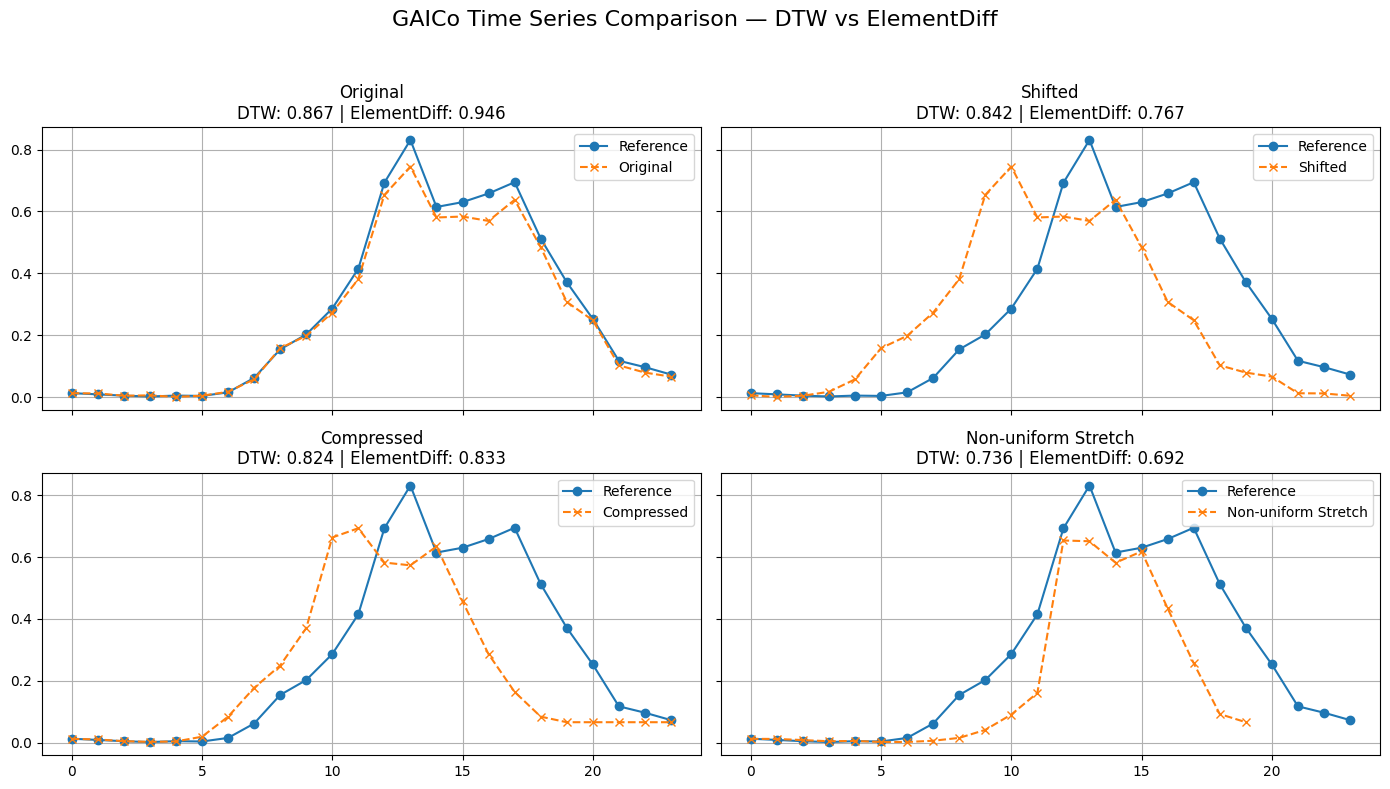

In [8]:
# --- Reference Series ---
reference = full_series[7 * 24 : 8 * 24]
reference_str = series_to_gaico_str(reference)


# --- Perturbation Functions ---
def stretch_series(series, stretch_factor):
    x_original = np.arange(len(series))
    x_stretched = np.linspace(0, len(series) - 1, int(len(series) * stretch_factor))
    interpolator = interp1d(x_original, series, kind="linear")
    return interpolator(x_stretched).tolist()


variation = full_series[14 * 24 : 15 * 24]

# --- Perturbed Variants ---
perturbations = {
    "Original": variation,
    "Shifted": variation[3:] + variation[:3],
    "Compressed": (stretch_series(variation, 20 / 24) + [variation[-1]] * 4)[:24],
    "Non-uniform Stretch": stretch_series(variation[:12], 16 / 12)[:12]
    + stretch_series(variation[12:], 8 / 12)[:12],
}

# --- Compute Scores and Store for Plotting ---
scores = []
for label, variant in perturbations.items():
    variant_str = series_to_gaico_str(variant)

    dtw_score = TimeSeriesDTW(similarity_method="reciprocal").calculate(variant_str, reference_str)
    diff_score = TimeSeriesElementDiff(key_to_value_weight_ratio=2.0).calculate(
        variant_str, reference_str
    )

    scores.append((label, variant, dtw_score, diff_score))

# --- Plotting ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (label, variant, dtw_score, diff_score) in zip(axes, scores):
    ax.plot(reference, label="Reference", marker="o")
    ax.plot(variant, label=label, linestyle="--", marker="x")
    ax.set_title(f"{label}\nDTW: {dtw_score:.3f} | ElementDiff: {diff_score:.3f}")
    ax.grid(True)
    ax.legend()

fig.suptitle("GAICo Time Series Comparison — DTW vs ElementDiff", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Key Takeaways

- **Precision**: `TimeSeriesElementDiff` is best when timestamps matter.
- **Flexibility**: `TimeSeriesDTW` handles delays and distortions smoothly.
- **Unified Output**: Both metrics return normalized scores in `[0, 1]`, ideal for consistent evaluation across datasets.

For more advanced usage, try:

- Tuning weights in `ElementDiff`
- Switching to `'gaussian'` similarity in `DTW`
